# 2D cell tracking with Ultrack and Stardist

The goal of this document is to present Ultrack's programming interface.
We use Stardist for segmentation because its available weights are reliable for 2D nuclei segmentation.
However, any algorithm other could be used or even multiple segmentation masks are allowed.

The tracking procedure can be roughly divided into two stages:
- Obtaining cell detections and their boundaries (e.g. edges);
- Compute tracking from detection and edges.

First, we download demostration dataset from cell-tracking challenge.

In [2]:
!wget -nc http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DL-HeLa.zip
!unzip -n Fluo-N2DL-HeLa.zip

File ‘Fluo-N2DL-HeLa.zip’ already there; not retrieving.

Archive:  Fluo-N2DL-HeLa.zip


We set some environment variables and import the required python packages.

In [1]:
# stardist / tensorflow env variables setup
import os
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from pathlib import Path

import napari
import numpy as np
from napari.utils.notebook_display import nbscreenshot
from tqdm import tqdm
from rich.pretty import pprint

from stardist.models import StarDist2D

from ultrack import track, to_tracks_layer, tracks_to_zarr
from ultrack.imgproc import normalize
from ultrack.utils import estimate_parameters_from_labels, labels_to_edges
from ultrack.utils.array import array_apply
from ultrack.config import MainConfig
from tifffile import imread, imwrite


2023-11-16 19:48:39.725987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Computing cell detection and boundaries

We set the download dataset path, open a napari viewer and open the images using napari's default reader.

In [2]:
# image path, change this
# (T, Y, X, C) data, where T=time, Y, X =s patial coordinates and C=channels
img_path = Path("../data/test.tif")

# optional, useful for a quick look
# for all frames `n_frames = None`
n_frames = 200

imgs = imread(img_path)
imgs = imgs[:, 1:, :, :]

# chunks = (1, *imgs.shape[1:-1], 1) # chunk size used to compress data

if n_frames is not None:
    imgs = imgs[:n_frames]
imgs = np.swapaxes(imgs, 1, 3)


# dataset_path = Path("Fluo-N2DL-HeLa/01")


viewer = napari.Viewer()
viewer.window.resize(1800, 1000)
# viewer.open(sorted(dataset_path.glob("*.tif")), stack=True)
layers = viewer.add_image(imgs, channel_axis=3, name="raw")

image=np.mean([viewer.layers[i].data for i in [0, 1, 2]], axis=0)


# nbscreenshot(viewer)

Using the `predict` helper function we compute the Stardist results.

In [3]:
%%capture
model = StarDist2D.from_pretrained("2D_versatile_fluo")
stardist_labels = np.zeros_like(image, dtype=np.int32)

def predict(frame: np.ndarray, model: StarDist2D) -> np.ndarray:
    """Normalizes and computes stardist prediction."""
    frame = normalize(frame, gamma=1.0)
    labels, _ = model.predict_instances_big(
        frame, "YX", block_size=560, min_overlap=96, show_progress=False,
    )
    return labels

array_apply(
    image,
    out_array=stardist_labels,
    func=predict,
    model=model,
)

viewer.add_labels(stardist_labels, name="stardist")

In [4]:
image.shape

(200, 1024, 1024)

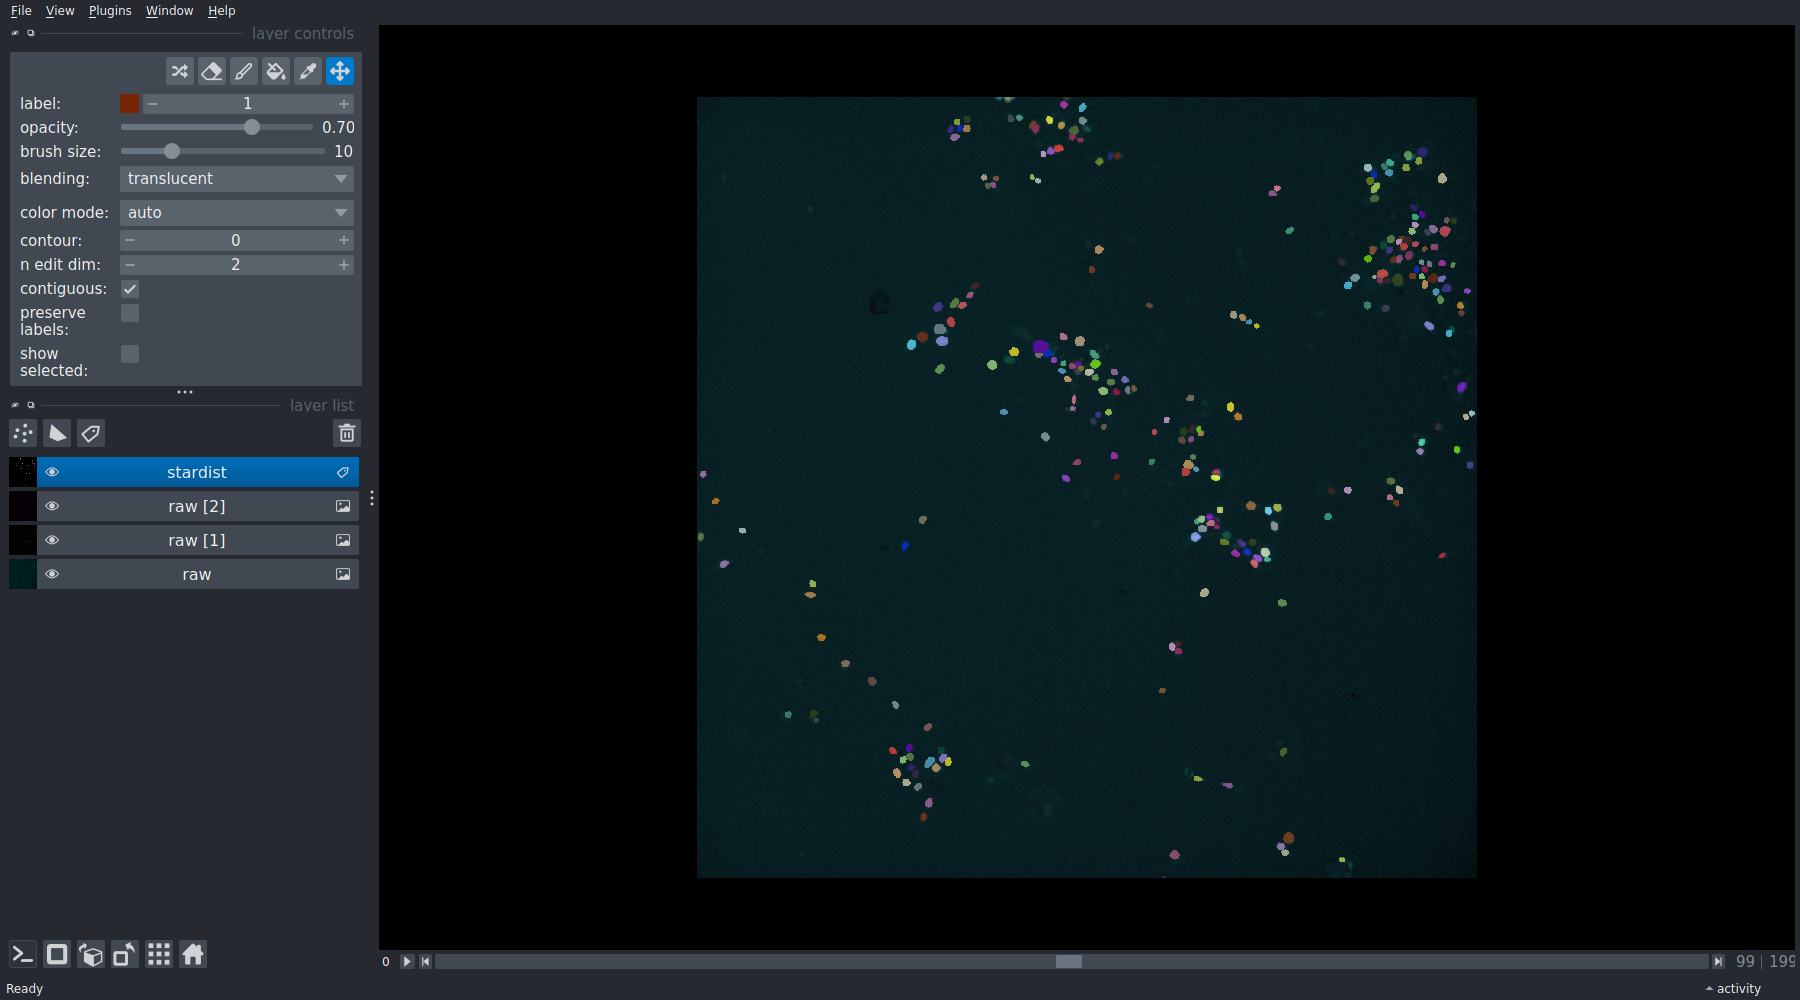

In [5]:
nbscreenshot(viewer)

The `labels_to_edges` converts labels into Ultrack's expected input, a detection and edges maps (cells' boundaries). The `sigma` parameter blurs the cell boundaries, assisting the segmentation hypothesis estimation, the goal is to make the boundaries similar to a distance transform inside the cells.

In [6]:
detection, edges = labels_to_edges(stardist_labels, sigma=4.0)  # multiple labels can be used with [labels_0, labels_1, ...]

Converting labels to edges: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:18<00:00, 11.04it/s]


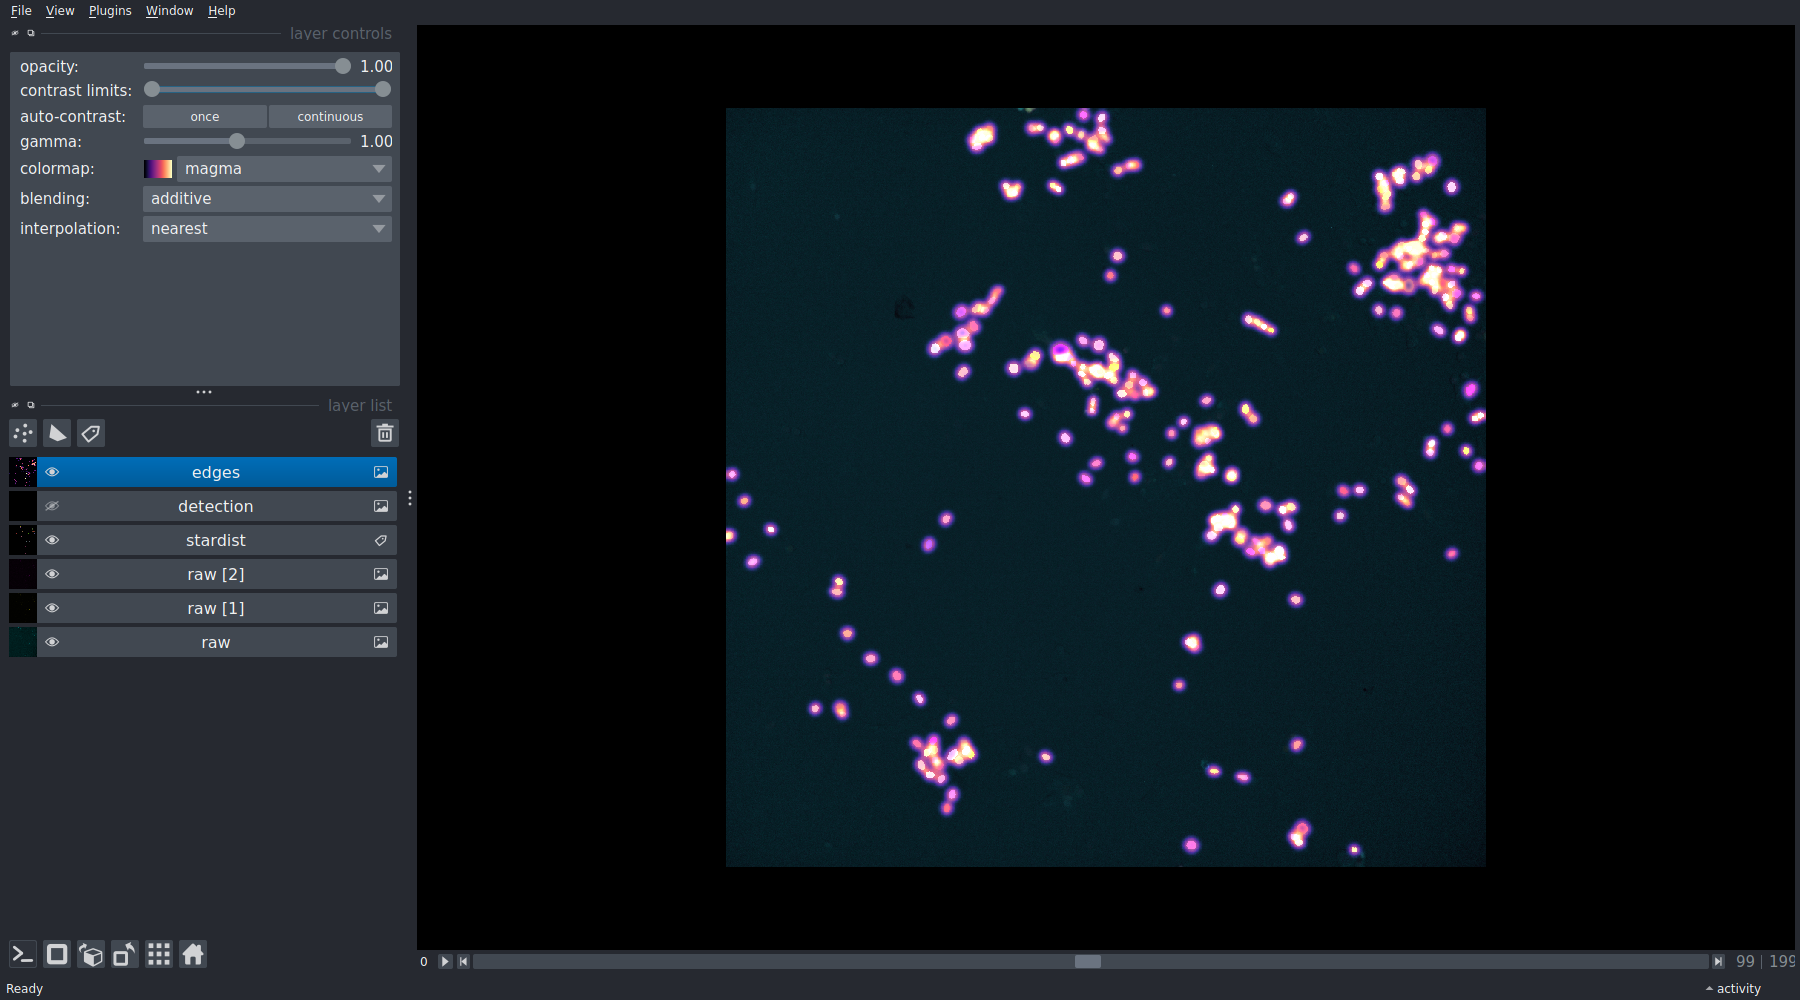

In [7]:
viewer.add_image(detection, visible=False)
viewer.add_image(edges, blending="additive", colormap="magma")
nbscreenshot(viewer)

## 2. Tracking

Now that we have our `detection` and `edges` you can call the `track` function for the tracking on the contour representation of the cells.

The `track` function is composed of three steps that can also be called individually:
- `segment`: Computes the segmentation hypothesis for tracking;
- `link`: Links and assign edge weights to the segmentation hypothesis;
- `solve`: Solves the tracking problem by selecting the strongly connected segmentation hypothesis.

Each of these steps requires its own configuration, which we'll set up below. Its documentation can be found [here](https://github.com/royerlab/ultrack/blob/main/ultrack/config/README.md).

We create our configuration instance and print its default values.

In [8]:
config = MainConfig()
pprint(config)

MainConfig(
│   data_config=DataConfig(working_dir=PosixPath('.'), database='sqlite', address=None, n_workers=1),
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=100,
│   │   max_area=1000000,
│   │   min_frontier=0.0,
│   │   anisotropy_penalization=0.0,
│   │   max_noise=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x7f50c22d0280>,
│   │   n_workers=1
│   ),
│   linking_config=LinkingConfig(
│   │   n_workers=1,
│   │   max_neighbors=5,
│   │   max_distance=15.0,
│   │   distance_weight=0.0,
│   │   z_score_threshold=5.0
│   ),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-0.001,
│   │   disappear_weight=-0.001,
│   │   division_weight=-0.001,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=None,
│   │   overlap_size=1,
│   │   solution_gap=0.001,
│   │   time_limit=36000,
│   │   method=0,
│   │   n_threads=-1,
│   │   link_function='power',
│   │   power=4,
│   │   bias=-0.0
│   )
)

To assist setting the parameters we inspect Stardist's results using the function `estimate_params_from_labels` from `ultrack.utils`.
The `min_area` was selected to eliminate a few small segments which could be noise or incorrect segmentations.
For the `max_area` we also avoid the right tail of the distribution because it could also be outliers.

Estimating params.: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 43.39it/s]


<Axes: title={'center': 'Area histogram'}, ylabel='Frequency'>

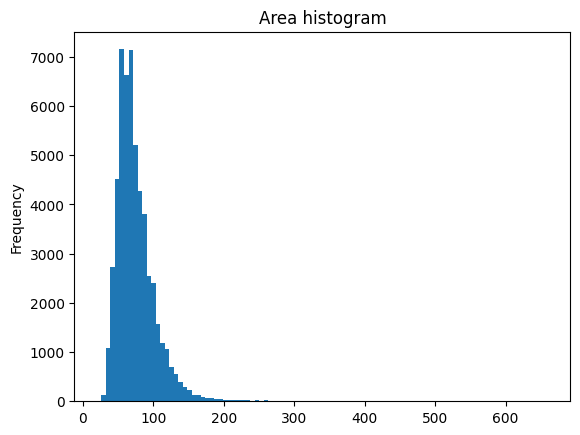

In [9]:
params_df = estimate_parameters_from_labels(stardist_labels, is_timelapse=True)
params_df["area"].plot(kind="hist", bins=100, title="Area histogram")

In [10]:
config.segmentation_config.min_area = 50
config.segmentation_config.max_area = 950
config.segmentation_config.n_workers = 8

The remaining parameters are harder to estimate without ground-truth data, hence they were tuned by trial and error.
From our experience setting the `power` parameter to 3 or 4 yields better results, specially in challenging scenarios. Note that, you must adjust the other `*_weight` accordingly when `power` is updated.

In [11]:
config.linking_config.max_distance = 25
config.linking_config.n_workers = 8

config.tracking_config.appear_weight = -1
config.tracking_config.disappear_weight = -1
config.tracking_config.division_weight = -0.1
config.tracking_config.power = 4
config.tracking_config.bias = -0.001
config.tracking_config.solution_gap = 0.0

pprint(config)

MainConfig(
│   data_config=DataConfig(working_dir=PosixPath('.'), database='sqlite', address=None, n_workers=1),
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=50,
│   │   max_area=950,
│   │   min_frontier=0.0,
│   │   anisotropy_penalization=0.0,
│   │   max_noise=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x7f50c22d0280>,
│   │   n_workers=8
│   ),
│   linking_config=LinkingConfig(
│   │   n_workers=8,
│   │   max_neighbors=5,
│   │   max_distance=25,
│   │   distance_weight=0.0,
│   │   z_score_threshold=5.0
│   ),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-1,
│   │   disappear_weight=-1,
│   │   division_weight=-0.1,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=None,
│   │   overlap_size=1,
│   │   solution_gap=0.0,
│   │   time_limit=36000,
│   │   method=0,
│   │   n_threads=-1,
│   │   link_function='power',
│   │   power=4,
│   │   bias=-0.001
│   )
)

Now, we only need to execute the `track` functions with the configuration we just created and the input images.

In [ ]:
track(
    detection=detection,
    edges=edges,
    config=config,
    overwrite=True,
)

Adding nodes to database:   0%|                                                                                                                                                                                                                                                                                                                                                                           | 0/200 [00:00<?, ?it/s]

The `to_tracks_layer` and `tracks_to_zarr` export the solution into a napari compatible format.

In [ ]:
tracks_df, graph = to_tracks_layer(config)
labels = tracks_to_zarr(config, tracks_df)

In [ ]:
viewer.add_tracks(tracks_df[["track_id", "t", "y", "x"]].values, graph=graph)
viewer.add_labels(labels)

viewer.layers["stardist"].visible = False
viewer.layers["edges"].visible = False

nbscreenshot(viewer)